In [ ]:
import numpy as np
import flopy
import flopy.utils.binaryfile as bf
import matplotlib.pyplot as plt

MF2005_EXE='./mf2005'
MT3DMS_EXE='./mt3dms'

INPUT_AQUIFER  = 'aquifer'
MODEL_NAME = 'aquifer'

In [ ]:
# aquifer size


delx = 1
dely = 1
delz = 1

lambdax = 25
lambday = 25
lambdaz = 5

nlay = lambdaz*3
nrow = lambday*3
ncol = lambdax*6

ztop = 0.
zbot = np.zeros((nlay, nrow, ncol))
for i in range(nlay):
    zbot[i, :, :] = ztop - delz*(i+1)
    
# flow boundary condition

ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)
ibound[:, :, 0] = -1
ibound[:, :, -1] = -1
    
strt = np.ones((nlay, nrow, ncol), dtype=np.float32)
strt[:, :, 0] = ncol
strt[:, :, -1] = 0

lrcq = {}
lrcq[0] = []
for i in range(lambdax,lambdax*2):
    for j in range(lambday,lambday*2):
        lrcq[0].append([nlay-1, j, i, 1.])

# contamination source

initial=np.zeros((nlay,nrow,ncol))
for i in range(lambdax,lambdax*2):
    for j in range(lambday,lambday*2):
        initial[nlay-1, j, i] = 1
# ssmdata = {}
# ssmdata[0] = []
# itype = flopy.mt3d.Mt3dSsm.itype_dict()
# for i in range(10,20):
#     for j in range(15,25):
#         ssmdata[0].append([nlay-1, j, i, 1, itype['WEL']])
        
tlim=50
times=np.linspace(0, tlim, num=151)

In [9]:
print(nlay, nrow, ncol)

15 75 150


In [10]:
#load SGeMS
sgems=np.loadtxt(INPUT_AQUIFER, skiprows=1, delimiter=',')

#Reshape SGeMS data
aquifer=np.zeros((nlay,nrow,ncol))
aquifer=np.reshape(sgems.T,(nlay,nrow,ncol))
np.save('sgemsaquifer',aquifer)

In [11]:
hk = np.exp(aquifer)
#hk = np.ones((nlay, nrow, ncol))

In [12]:
# Aquifer name
modelname = MODEL_NAME
        
# MODFLOW
mf = flopy.modflow.Modflow(modelname, exe_name=MF2005_EXE)
dis = flopy.modflow.ModflowDis(mf, nlay=nlay, nrow=nrow, ncol=ncol, delr=delx, delc=dely, top=ztop, botm=zbot, nper=1, perlen=tlim)
bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)
lpf = flopy.modflow.ModflowLpf(mf, hk=hk)
wel = flopy.modflow.ModflowWel(mf, stress_period_data=lrcq)
oc = flopy.modflow.ModflowOc(mf)
pcg = flopy.modflow.ModflowPcg(mf)
lmt = flopy.modflow.ModflowLmt(mf, output_file_header='extended', output_file_format='formatted', output_file_name=modelname+".ftl")
mf.write_input()
success, buff = mf.run_model()


FloPy is using the following  executable to run the model: ./mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: aquifer.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2020/09/21 23:26:56

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2020/09/21 23:27:02
 Elapsed run time:  6.011 Seconds

  Normal termination of simulation


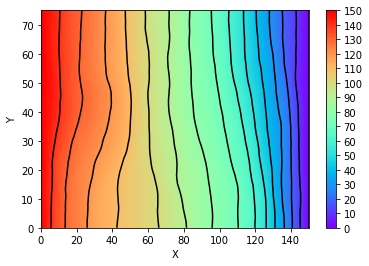

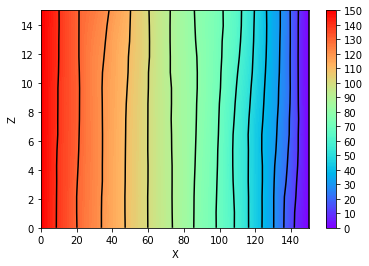

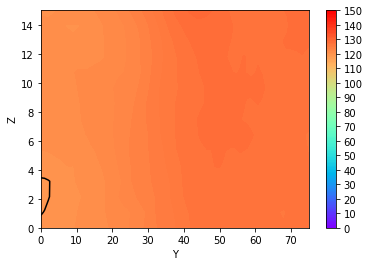

In [13]:
#Basic variables
Lx=(ncol)*delx
Ly=(nrow)*dely
Lz=(nlay)*delz
hg = ncol

levelh=np.arange(0,hg+1,1)
levelhl=np.arange(0,hg+1,10)
extent=(0., Lx, 0, Ly)
hds = bf.HeadFile('aquifer.hds')
head = hds.get_data(totim=tlim)

#plt.subplot(1,1,1,aspect='equal')
b=plt.contourf(head[-1,:,:], levels=levelh, extent=extent, cmap=plt.cm.rainbow)
plt.contour(head[-1,:,:], colors=('0'), levels=levelhl, extent=extent)
plt.xlabel('X')
plt.ylabel('Y')
plt.colorbar(b, ticks=levelhl, orientation='vertical')
plt.savefig('hh',dpi=400)
plt.show()

extent=(0., Lx, 0, Lz)
#plt.subplot(1,1,1,aspect='equal')
b=plt.contourf(head[:,int(nrow/2),:], levels=levelh, extent=extent, cmap=plt.cm.rainbow)
plt.contour(head[:,int(nrow/2),:], colors=('0'), levels=levelhl, extent=extent)
plt.xlabel('X')
plt.ylabel('Z')
plt.colorbar(b, ticks=levelhl, orientation='vertical')
plt.show()

extent=(0., Ly, 0, Lz)
#plt.subplot(1,1,1,aspect='equal')
b=plt.contourf(head[:,:,lambdax], levels=levelh, extent=extent, cmap=plt.cm.rainbow)
plt.contour(head[:,:,lambdax], colors=('0'), levels=levelhl, extent=extent)
plt.xlabel('Y')
plt.ylabel('Z')
plt.colorbar(b, ticks=levelhl, orientation='vertical')
plt.show()

In [14]:
f = open('aquifer.ftl', 'r')
cell_number = nlay * nrow * ncol
velocity_vector = np.zeros((cell_number,3))

for line in f:
    if line[3] == 'X':
        print(line)
        subline = f.readline().split()
        for j in range(cell_number):
            velocity_vector[j, 0] = float(subline[j])

    if line[3] == 'Y':
        print(line)
        subline = f.readline().split()
        for j in range(cell_number):
            velocity_vector[j, 1] = float(subline[j])

    if line[3] == 'Z':
        print(line)
        subline = f.readline().split()
        for j in range(cell_number):
            velocity_vector[j, 2] = float(subline[j])
        
f.close()


 'QXX             '

 'QYY             '

 'QZZ             '



In [15]:
import pyvista as pv

In [16]:
vgrid = np.zeros((cell_number, 3))
iteration = 0
deltal = 1
for l in range(nlay):
    for k in range(nrow):
        for j in range(ncol):
            vgrid[iteration] = np.array(([j*deltal,k*deltal,l*deltal]))
            iteration += 1            

In [17]:
np.max(velocity_vector)

27.0719032

In [ ]:
mt = flopy.mt3d.Mt3dms(modflowmodel=mf, modelname=modelname, namefile_ext='mtnam',
                       exe_name='./mt3dms', ftlfree=True, ftlfilename=modelname+".ftl")
btn=flopy.mt3d.Mt3dBtn(mt,prsity=0.4, sconc=initial, ncomp=1, nprs=1, timprs=times, savucn=True)
adv = flopy.mt3d.Mt3dAdv(mt, mixelm=3, percel=0.75, mxpart=8000000)
dsp = flopy.mt3d.Mt3dDsp(mt, al=0.01, trpt=0.1, trpv=0.01, dmcoef=1e-9)
rct = flopy.mt3d.Mt3dRct(mt,isothm=0, igetsc=0)
ssm = flopy.mt3d.Mt3dSsm(mt)
gcg = flopy.mt3d.Mt3dGcg(mt)
mt.write_input()
success, buff=mt.run_model()

FloPy is using the following  executable to run the model: ./mt3dms
 MT3DMS - Modular 3-D Multi-Species Transport Model [Version 5.30]
 Developed at University of Alabama for U.S. Department of Defense

 Using NAME File: aquifer.mtnam                                     

 STRESS PERIOD NO.    1

 TIME STEP NO.    1
 FROM TIME =   0.0000     TO    50.000    

 Transport Step:    1   Step Size:   0.000     Total Elapsed Time:   0.0000    
 Transport Step:    2   Step Size:  1.1356E-02 Total Elapsed Time:  1.13560E-02
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2869E-01  [K,I,J]   15   27   26
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5960E-07  [K,I,J]   15   26   26
 Transport Step:    3   Step Size:  1.1356E-02 Total Elapsed Time:  2.27120E-02
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2863E-01  [K,I,J]   15   30   50
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5960E-07  [K,I,J]   15   26   26
 Transport Step:    4   Step Size:  1.1356E-02 Total Elapsed Time:  3.40679E-0

In [27]:
#Check data okay
c=bf.UcnFile('MT3D001.UCN')
for k in range(0,51,10):
    extent=(0., Lx, 0, Lz)
    concentration=c.get_data(totim=k)
    plt.subplot(1,1,1,aspect='equal')
    plt.imshow(concentration[:, 14, :],extent=extent, cmap=plt.get_cmap('winter'), alpha=0.7, origin='lower', vmin=0, vmax=1)
    plt.xlabel('X')
    plt.ylabel('Z')
    plt.savefig('contamiant transport_'+str(k),dpi=400)
    plt.show()
    
    extent=(0., Lx, 0, Ly)
    plt.subplot(1,1,1,aspect='equal')
    plt.imshow(concentration[-1, :, :],extent=extent, cmap=plt.get_cmap('winter'), alpha=0.7, origin='lower', vmin=0, vmax=1)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'MT3D001.UCN'

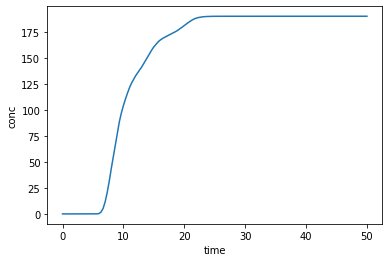

In [117]:
conc = np.zeros(len(c.get_times()))
init = np.sum(c.get_data(totim=0)[:,:,:lambdax*5])
cpc = 0

for k in range(len(c.get_times())):
    concentration=c.get_data(totim=c.get_times()[k])
    cpc += np.sum(concentration[:,:,lambdax*5])
    conc[k]=cpc
    
plt.plot(times, conc)
plt.xlabel('time')
plt.ylabel('conc')
plt.show()

In [118]:

wellgrid = np.zeros((lambdax*lambday, 3))
cpgrid = np.zeros((nlay*nrow, 3))

iteration = 0
deltal = 1
for l in range(nlay):
    for k in range(nrow):
        cpgrid[iteration] = np.array(([5*lambdax*deltal,k*deltal,l*deltal]))
        iteration += 1
iteration = 0        
for l in range(lambdax, lambdax*2):
    for k in range(lambday, lambday*2):
        wellgrid[iteration] = np.array(([l*deltal,k*deltal,(nlay-1)*deltal]))
        iteration += 1

In [120]:
point_cloud = pv.PolyData(vgrid)
point_cloud['vector'] = velocity_vector
point_cloud['conc0'] = c.get_data(totim=0).flatten()
point_cloud['conc1'] = c.get_data(totim=1).flatten()
point_cloud['conc10'] = c.get_data(totim=10).flatten()
point_cloud['conc20'] = c.get_data(totim=20).flatten()
point_cloud['conc30'] = c.get_data(totim=30).flatten()
point_cloud['conc40'] = c.get_data(totim=40).flatten()
point_cloud['conc50'] = c.get_data(totim=50).flatten()
wellgrid = pv.PolyData(wellgrid)
cpgrid = pv.PolyData(cpgrid)

point_cloud.save("vtk/mesh2.vtk")
wellgrid.save("vtk/wellgrid2.vtk")
cpgrid.save("vtk/cpgrid2.vtk")

In [23]:
point_cloud

PolyData (0x1f7214762e8)
  N Cells:	168750
  N Points:	168750
  X Bounds:	0.000e+00, 1.490e+02
  Y Bounds:	0.000e+00, 7.400e+01
  Z Bounds:	0.000e+00, 1.400e+01
  N Arrays:	8

In [24]:
wellgrid

PolyData,Information
N Cells,625
N Points,625
X Bounds,"2.500e+01, 4.900e+01"
Y Bounds,"2.500e+01, 4.900e+01"
Z Bounds,"1.400e+01, 1.400e+01"
N Arrays,0


In [25]:
cpgrid

PolyData,Information
N Cells,1125
N Points,1125
X Bounds,"1.250e+02, 1.250e+02"
Y Bounds,"0.000e+00, 7.400e+01"
Z Bounds,"0.000e+00, 1.400e+01"
N Arrays,0
